# **Exercise 5**

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import lsqr

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
location = "/content/drive/MyDrive/FML/Exercise5/hs_tomography/"

### **3) Constructing the matrix X**

We put the origin of the coordinate system into the center of the image. There we also place the detector's center. The $\alpha=0^\circ$ direction then corresponds to $\vec{n}=(1,0)$.

In [41]:
def construct_X(M, alphas, Np = None):
  '''
  Calculates and returns sparse weight matrix X
  '''
  # needed fixed paramters
  h = 1
  D = M**2
  if (Np == None):
    Np = np.ceil(np.sqrt(2) * M)
  No = alphas.shape[0]
  N = int(Np * No)

  # constructing matrix C
  # coordinates of tomogram's first pixel
  a_0 = - M / 2 + h / 2
  b_0 =  M / 2 - h / 2

  # indices of mu image
  j_a = np.arange(0, M)
  j_b = np.arange(0, M)

  #  coordinates of tomogram pixel
  # x-coordinates
  C_0 = a_0 + np.tile(j_a, M)
  # y-coordinates
  C_1 = b_0 - np.repeat(j_b, M)

  C = np.zeros((2, D))
  C[0, :] = C_0
  C[1, :] = C_1

  # projection 
  # array for image indices
  image_index = np.arange(0, D)
  col = np.tile(image_index, No * 2)
  # array for sensor indices
  row = np.empty((0))
  # array for weights
  data = np.empty((0))

  alphas = np.radians(alphas)

  # projection for every alpha
  for io, alpha in enumerate(alphas):

    # orientation vector
    n = np.array([np.cos(alpha), np.sin(alpha)])
    n = n[:, np.newaxis]

    # projection onto sensor
    p = n.T @ C + (Np / 2 - 0.5)
    p = np.squeeze(p)

    # calculating sensor indices
    sensor_index_1 = np.floor(p) + Np * io
    sensor_index_2 = np.ceil(p) + Np * io
    row = np.concatenate((row, sensor_index_1, sensor_index_2))

    # calculating weights
    weight_1 = 1 - (p - np.floor(p))
    weight_2 = 1 - weight_1
    data = np.concatenate((data, weight_1, weight_2))
  
  # creating sparse matrix
  X = coo_matrix((data, (row, col)), shape=(N, D))


  return(X)

In [42]:
# loading given example
file_example = "X_example.npy"
X_example = np.load(location + file_example)

In [43]:
# creating weight matrix with our function
alphas_example = np.array([-33, 1, 42])
X_test = construct_X(10, alphas_example, Np = None)
X_test_dense = X_test.toarray()

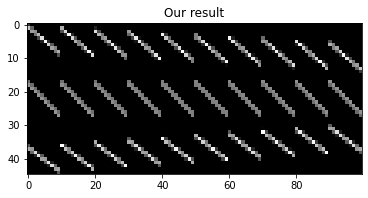

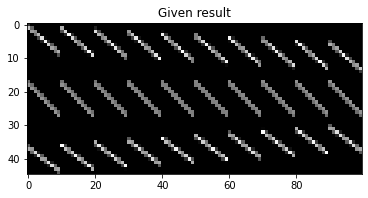

In [44]:
# Comparing our result with given result

plt.figure(0)
plt.title('Our result')
plt.imshow(X_test_dense, cmap='gray')
plt.show()

plt.figure(1)
plt.title('Given result')
plt.imshow(X_example, cmap='gray')
plt.show()

In [45]:
print('Row values from our result:\n', X_test_dense[3][0:20])

print('\n Row values from the example:\n', X_example[3][0:20])

Row values from our result:
 [0.         0.         0.45244792 0.70888151 0.         0.
 0.         0.         0.         0.         0.         0.15841639
 0.99708696 0.16424247 0.         0.         0.         0.
 0.         0.        ]

 Row values from the example:
 [0.         0.         0.45244792 0.7088815  0.         0.
 0.         0.         0.         0.         0.         0.15841639
 0.99708694 0.16424248 0.         0.         0.         0.
 0.         0.        ]


The plots suggest that out code works properly. This is also confirmed by looking at some values from the weight matrices.

### **4) Recovering the image**

i) Small data set:

At first we use the small data set, in order to examine, if our code works:

In [46]:
# loading given alphas
file_alphas_77 = "alphas_77.npy"
alphas_77 = np.load(location + file_alphas_77)

file_alphas_195 = "alphas_195.npy"
alphas_195 = np.load(location + file_alphas_195)

In [47]:
# loading given y's
file_y_77 = "y_77.npy"
y_77 = np.load(location + file_y_77)

print('y_77.shape:', y_77.shape)

file_y_195 = "y_195.npy"
y_195 = np.load(location + file_y_195)

print('y_195.shape:', y_195.shape)

y_77.shape: (9810,)
y_195.shape: (49225,)


In [48]:
# constructing small weight matrix X
# M=77, Np=109, No=90
%timeit X_77 = construct_X(77, alphas_77, Np = 109)
X_77 = construct_X(77, alphas_77, Np = 109)

1 loop, best of 3: 240 ms per loop


In [49]:
# reporting the sparsity of the matrix
num_total_77 = (77**2) * (109 * 90)
num_nonzero_77 = X_77.count_nonzero()
print('Number of nonzero elements: {0}, Number of total elements: {1}'.format(num_nonzero_77, num_total_77))

Number of nonzero elements: 1066978, Number of total elements: 58163490


istop: 1
itn: 1051


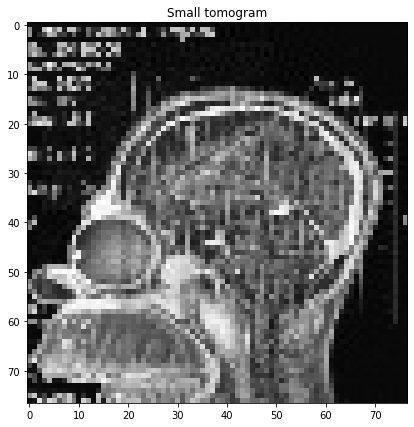

In [50]:
# Finding least squares solution with scipy built in function
atol = 1e-06
btol = 1e-06
beta, istop, itn = lsqr(X_77, y_77, atol=atol, btol=btol)[0:3]

print('istop:', istop)
print('itn:', itn)

# Reconstructed 2D mu image
mu = beta.reshape((77,77))

plt.figure(0, figsize=(7,7))
plt.title('Small tomogram')
plt.imshow(mu, cmap='gray')
plt.show()

So we are able to recognize a head in the small tomogram. Hence, we assume our code to be correct.

ii) Large data set:

In [51]:
# constructing small weight matrix X
# M=195, Np=275, No=179
%timeit X_195 = construct_X(195, alphas_195, Np = 275)
X_195 = construct_X(195, alphas_195, Np = 275)

1 loop, best of 3: 6.14 s per loop


In [52]:
# reporting the sparsity of the matrix
num_total_195 = (195**2) * (275 * 179)
num_nonzero_195 = X_195.count_nonzero()
print('Number of nonzero elements: {0}, Number of total elements: {1}'.format(num_nonzero_195, num_total_195))

Number of nonzero elements: 13535953, Number of total elements: 1871780625


In [53]:
# Finding least squares solution with scipy built in function
atol = 1e-06
btol = 1e-06
beta, istop, itn = lsqr(X_195, y_195, atol=atol, btol=atol)[0:3]

print('istop:', istop)
print('itn:', itn)

# Reconstructed 2D mu image
mu = beta.reshape((195,195))


istop: 1
itn: 881


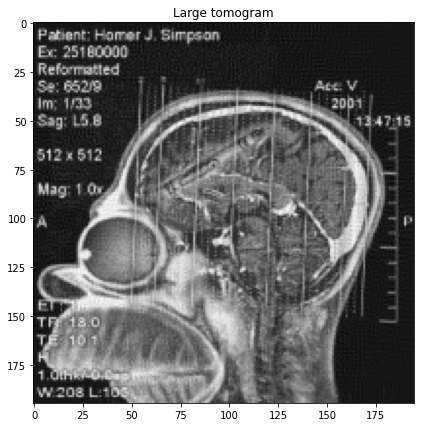

In [54]:
plt.figure(1, figsize=(7,7))
plt.title('Large tomogram')
plt.imshow(mu, cmap='gray')
plt.show()

Diagnosis: Patient seems to have some kind of pen in the upper part of his brain.

### **5) Minimizing the radiation dose**


In [55]:
print('alphas:\n', alphas_195)

alphas:
 [-90 -89 -88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73
 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55
 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37
 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19
 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1
   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88]


In the following we sensibly reduce the number of projection angles. We still want to equally distribute the angles over the range $[-90^\circ...88^\circ]$. Hence, we reduce the number of angles by removing and  then keeping every n'th angle. We then show the resulting tomogram and number of remaining projection angles:

In [56]:
def adapt_alphas(alphas, y, Np, No, M, step_drop, step_keep, drop=True):
  '''
  Drops or keeps every n'th projection angle and corresponding y value.  
  A new weight matrix X_new is calculated. The resulting mu image
  and the number of kept projection angles are returned.
  '''
  N_alphas = len(alphas)
  indices = np.arange(N_alphas)

  # dropping every n'th angle
  if drop:
    # indices of alpha angles, which are dropped
    indices_drop = indices[1 : : step_drop]
    indices_drop = set(indices_drop)

    mask = np.array([(i not in indices_drop) for i in range(len(alphas))])
    
    # new alpha array
    alphas_new = alphas[mask]

    # dropping corresponding y values
    y_temp = y.reshape((No, Np))
    y_temp = y_temp[mask]
    y_new = y_temp.flatten()
  
  # keeping every n'th angle
  else:
    # new alpha array
    alphas_new = alphas[1 : : step_keep]

    # keeping corresponding y values
    y_temp = y.reshape((No, Np))
    y_temp = y_temp[1 : : step_keep]
    y_new = y_temp.flatten()

  # number of projection angles that are kept
  N_alphas_kept = len(alphas_new)

  # calculating weight matrix
  X_new = construct_X(M, alphas_new, Np = Np)

  # leas square solution
  atol = 1e-06
  btol = 1e-06
  beta, istop, itn = lsqr(X_new, y_new, atol=atol, btol=btol)[0:3]
  
  mu = beta.reshape((M, M))

  return(mu, N_alphas_kept)

At first we reduce the number of alphas by dropping every n'th value with $n=[7, 6, 5,...,2]$ and then further reduce the number of angles by only keeping every n'th value with $n=[3, 4, 5, 6]$

Current step_drop: 7
Current step_drop: 6
Current step_drop: 5
Current step_drop: 4
Current step_drop: 3
Current step_drop: 2
Current step_keep: 3
Current step_keep: 4
Current step_keep: 5
Current step_keep: 6


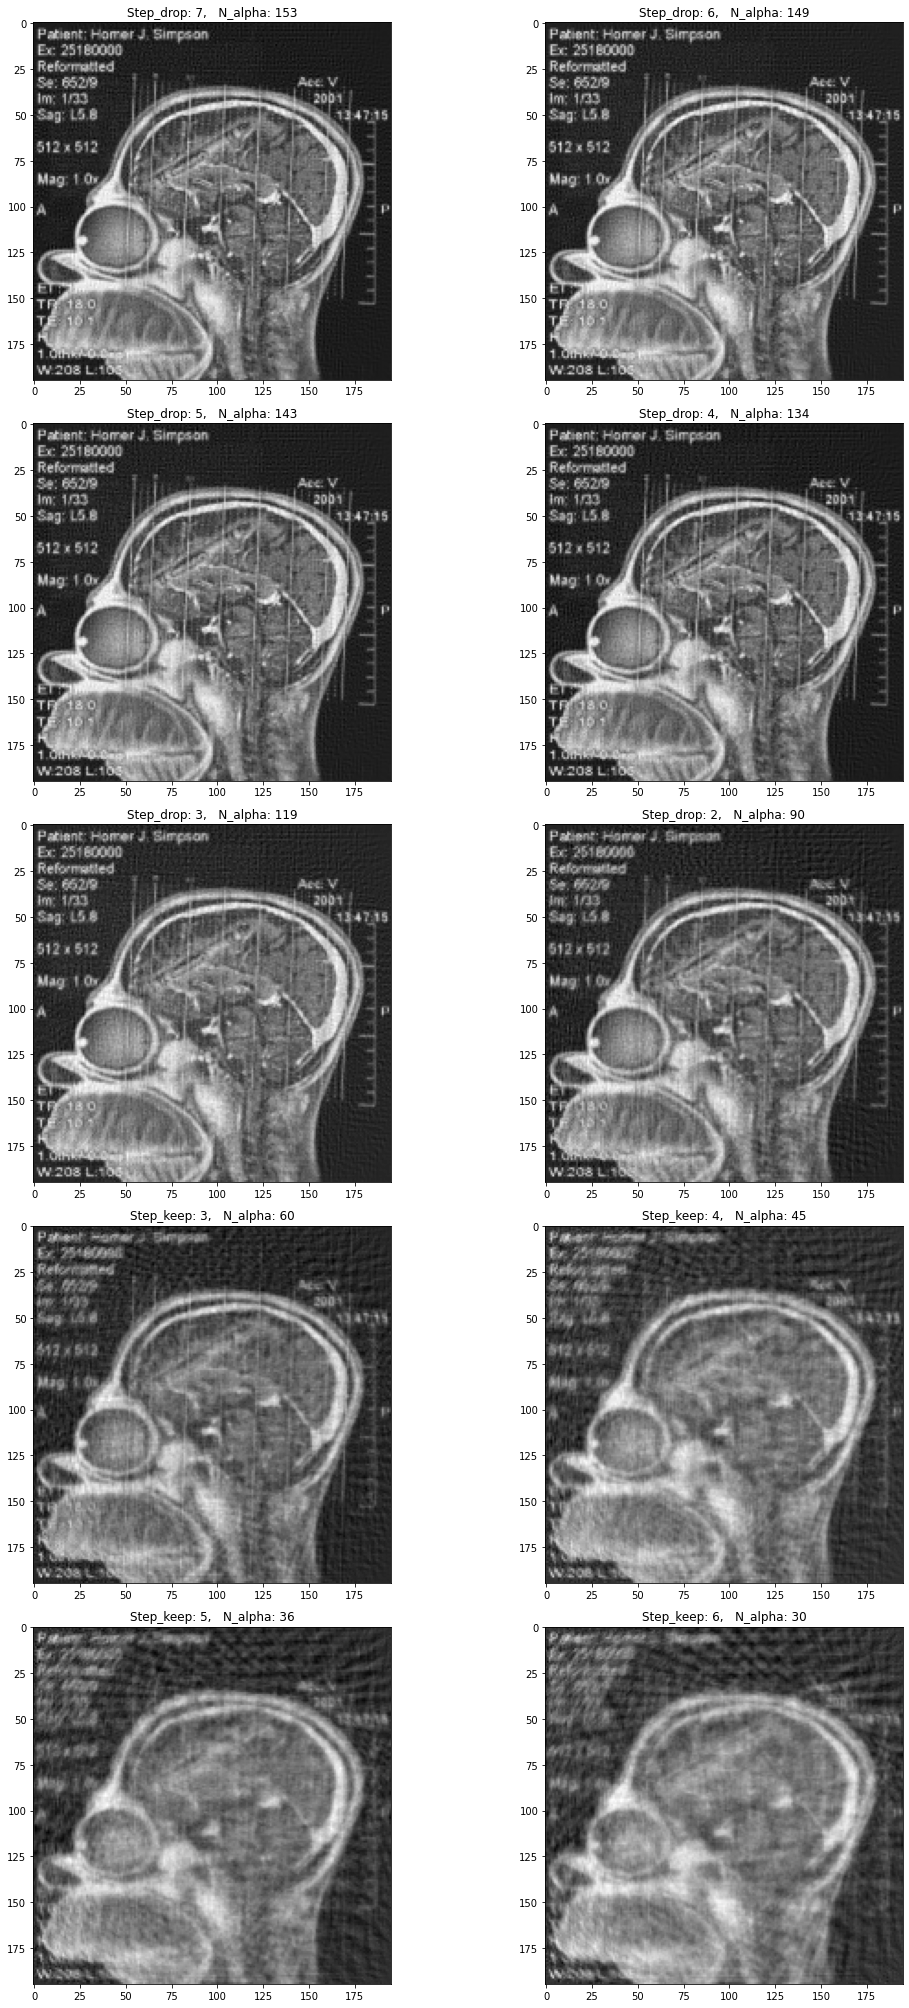

In [57]:
# drop every n'th value
step_drop_arr = np.arange(2, 8)
step_drop_arr = np.flip(step_drop_arr)

fig = plt.figure(figsize=(16,28))

# looping over the n'th drop values
for i, step_drop in enumerate(step_drop_arr):
  print('Current step_drop:', step_drop)
  
  mu, N_alphas_kept = adapt_alphas(alphas_195, y_195, 275, 179, 195, step_drop, 0, drop=True)

  ax = fig.add_subplot(5, 2 , i+1)
  plt.imshow(mu, cmap='gray')
  ax.set_title('Step_drop: {0},   N_alpha: {1}'.format(step_drop, N_alphas_kept))



# keep every n'th value
step_keep_arr = np.arange(3, 7)

# looping over the n'th keep values
for i, step_keep in enumerate(step_keep_arr):
  print('Current step_keep:', step_keep)

  mu, N_alphas_kept = adapt_alphas(alphas_195, y_195, 275, 179, 195, 0, step_keep, drop=False)

  ax = fig.add_subplot(5, 2 , i+7)
  plt.imshow(mu, cmap='gray')
  ax.set_title('Step_keep: {0},   N_alpha: {1}'.format(step_keep, N_alphas_kept))

plt.tight_layout()
plt.show()


If one is only interested in what causes the headache, the minimal number of projection angles needed, lies between 60 and 90. In that range it is still possible to see that some item is loacated in the upper part of the brain. But if one further wants to find out what kind of item it is, this resolution is not sufficient. In order to reolve that it is a pen one at least needs  90-119 projection angles. Only in that range it is starting to become clear that a pen is located in the brain.